In [1]:
import pypsa 
import pandas as pd
import numpy as np

## Definition der Variablen

In [2]:
#infeed renewables
pv_data = pd.read_csv('data/pv_data.csv', skiprows = 3)['electricity']
wind_data = pd.read_csv('data/wind_data.csv', skiprows = 3)['electricity']
hydrogen_data = pd.read_csv('data/load_hydrogen_1.csv',header = 0, sep= ';', decimal = ',')['elektrische Last']

#marginal cost
#hydrogen_cost = 1 #€/MWh

electricity_cost = 1 #€/MWh
marginal_cost_electrolysis = 1 #€/MWh
marginal_cost_wind = 1 #€/MW
marginal_cost_pv = 1 #€/MW
marginal_cost_grid = 1 #€/MW
marginal_cost_shipping_1 = 1 #€/MW
marginal_cost_shipping_2 = 1 #€/MW

#capital_cost 
capital_cost_electrolysis = 1 #€/MW annual
capital_cost_hydrogen_store_1 = 1 #€/MW annual 
capital_cost_hydrogen_store_2 = 1 #€/MW annual 
capital_cost_hydrogen_store_3 = 1 #€/MW annual 

#settings for efficiency of components
efficiency_electrolysis = 1

#power values (if not extendable)
power_electrolysis = 10 #kW
power_wind = 6000 #kW

#capacity values (if not extendable)
capacity_hydrogen_store = 100 #kWh

In [3]:
pv_data

0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
         ...   
8755    126.003
8756    106.421
8757     80.274
8758     44.620
8759      1.454
Name: electricity, Length: 8760, dtype: float64

In [4]:
hydrogen_data

0       0.433394
1       1.030247
2       0.542903
3       0.584443
4       0.524573
          ...   
8755    0.541104
8756    0.851679
8757    0.424584
8758    0.641945
8759    0.413122
Name: elektrische Last, Length: 8760, dtype: float64

## Netzwerk aufbauen

In [5]:
network = pypsa.Network()
network.set_snapshots(range(8760))

In [6]:
#Buses
network.add('Bus', name = 'electricity_pv')
#network.add('Bus', name = 'electricity_wind')
network.add('Bus', name = 'hydrogen')
#network.add('Bus', name = 'bremerhaven')
#network.add('Bus', name = 'koeln')

#Generators
network.add('Generator', name = 'grid', bus = 'electricity_pv', 
            p_nom = hydrogen_data.max() * efficiency_electrolysis, 
            marginal_cost = marginal_cost_grid)
network.add('Generator', name = 'pv', bus = 'electricity_pv', 
            p_nom_extendable = True, p_max_pu = pv_data,
            marginal_cost = marginal_cost_pv)
#network.add('Generator', name = 'wind_turbine', bus = 'electricity_wind', 
#            p_set = wind_data,
#            marginal_cost = marginal_cost_wind)

#Load
network.add('Load', name = 'hydrogen_load', bus = 'hydrogen', p_set = hydrogen_data)
#TODO: bus nach Köln ändern

#Links
network.add('Link', name = 'electrolysis_pv', bus0 = 'electricity_pv', bus1 = 'hydrogen', 
            p_nom_extendable = True, efficiency = efficiency_electrolysis, 
            capital_cost = capital_cost_electrolysis,
            marginal_cost = marginal_cost_electrolysis)
#network.add('Link', name = 'electrolysis_wind', bus0 = 'electricity_wind', bus1 = 'hydrogen', 
#            p_nom_extendable = True, efficiency = efficiency_electrolysis, 
#            capital_cost = capital_cost_electrolysis,
#            marginal_cost = marginal_cost_electrolysis)

#TODO: Transportwege hinzufügen
#network.add('Link', name = 'shipping_1', bus0 = 'hydrogen', bus1 = 'bremerhaven',
#            marginal_cost = marginal_cost_shipping_1)
#network.add('Link', name = 'shipping_2', bus0 = 'bremerhaven', bus1 = 'koeln',
#            marginal_cost = marginal_cost_shipping_2)

#Stores
#network.add('Store', name = 'hydrogen_store_1', e_cyclic = True, 
#            bus = 'hydrogen', e_nom_extendable = True, capital_cost = capital_cost_hydrogen_store_1)
#network.add('Store', name = 'hydrogen_store_2', e_cyclic = True, 
#            bus = 'bremerhaven', e_nom_extendable = True, capital_cost = capital_cost_hydrogen_store_2)
#network.add('Store', name = 'hydrogen_store_3', e_cyclic = True, 
#            bus = 'koeln', e_nom_extendable = True, capital_cost = capital_cost_hydrogen_store_3)

In [7]:
network.lopf(pyomo = False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 9.01e+03


('ok', 'optimal')

<AxesSubplot:xlabel='snapshot'>

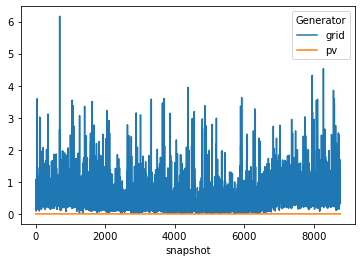

In [8]:
network.generators_t.p.plot()

In [9]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
grid,electricity_pv,Slack,,6.165332,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,6.165332
pv,electricity_pv,PQ,,0.000000,True,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.000000


In [10]:
network.stores.e_nom_opt

Series([], Name: e_nom_opt, dtype: float64)

In [11]:
network.links.p_nom_opt 

Link
electrolysis_pv    6.16533
Name: p_nom_opt, dtype: float64